In [2]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

The toy problem explores a 2-qubit system:
$$\big|\psi\rangle=\alpha\big|00\rangle+\beta\big|01\rangle+\gamma\big|10\rangle+\delta\big|11\rangle$$
where the amplitude for each state is a complex number while $\left|\alpha\right|^{2} = \left|\beta\right|^{2} + \left|\gamma\right|^{2} + \left|\delta\right|^{2} = 1$.

The quantum gates are unitary operation. We can pick some gates that are in SU(2), namely, Ry and Rz rotational gate.

$$R_y(\theta) = \left[\begin{array}{cc}
\cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \\
\sin \frac{\theta}{2} & \cos \frac{\theta}{2}
\end{array}\right]$$
$$R_z(\theta) = \left[\begin{array}{cc}
e^{-i \theta / 2} & 0 \\
0 & e^{i \theta / 2}
\end{array}\right]$$

Since the qubit can also be represented on a Bloch sphere and ZYZ can specify any rotation, the qubit seems to be a homogeneous vector space for SU(2). As a result, we want to construct a NN that is equivariant to SU(2).

To construct a problem for NN to solve, we can choose regression or classification.

Regression: Input = The final statevector* (the 4 complex amplitudes); Output = The angle for each rotation

Classification: WIP. Classify between entangled and not entangled states?

*Note that the statevector is not measurable in the real world. We can only measure the qubit in a certain basis ($\langle \psi \big| \sigma_z  \big| \psi \rangle$) 

## Visualize Data

In [3]:
# Loading Dataset
hf = h5py.File("WIP_toy_qubit_regression.hdf5", "r")
hf.keys()
X = np.array(hf.get("statevector"))
Y = np.array(hf.get("angles"))

In [4]:
# split the complex number into separate real and imag part
def splitc(l):
    splited = []
    for i in l:
        splited.append(i.real)
        splited.append(i.imag)
    return splited
X_splited = np.apply_along_axis(splitc, 1, X)
print(X_splited.shape)

(100000, 8)


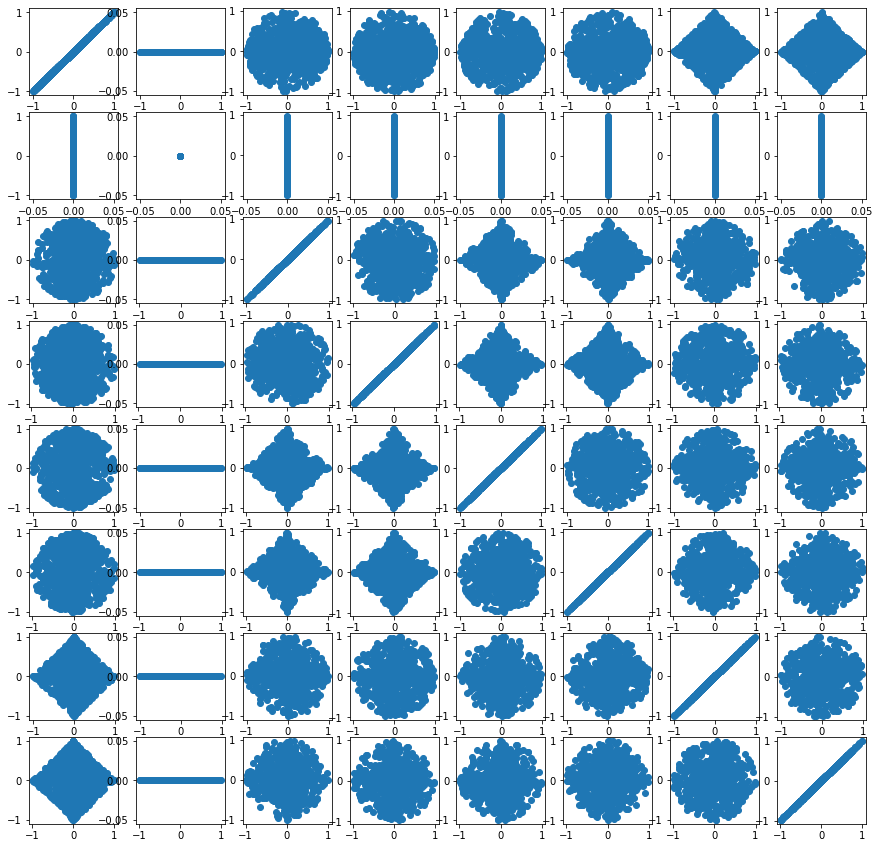

In [5]:
fig, ax = plt.subplots(8,8, figsize=(15,15))
for i in range(8):
    for j in range(8):
        ax[i,j].scatter(X_splited[:1000,i], X_splited[:1000,j])
plt.show()

## Train a Regression NN

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_splited, Y, test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.2)

In [8]:
print(x_test.shape,x_val.shape)

(16000, 8) (4000, 8)


In [9]:
class Net(nn.Module):
    def __init__(self, d_in, d_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(d_in, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, d_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
model = Net(d_in = 8, d_out = 6)
model.to(device)
print(model)

Net(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
)


In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
criterion = torch.nn.MSELoss()

In [ ]:
epochs = 10
train_losses = []
val_losses = []
for e in range(epochs):
    train_lossx = 0
    for i, sample in enumerate(x_train):
        inputv = Variable(torch.as_tensor([sample]).float()).to(device)
        targetv = Variable(torch.as_tensor([y_train[i]]).float()).to(device)
        
        output = model(inputv)
        loss = criterion(output, targetv)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_lossx += loss
    val_lossx = 0
    with torch.no_grad():
        for i, sample in enumerate(x_val):
            inputv = Variable(torch.as_tensor([sample]).float()).to(device)
            targetv = Variable(torch.as_tensor([y_val[i]]).float()).to(device)

            output = model(inputv)
            loss = criterion(output, targetv)
            
            val_lossx += loss
            
    avg_train_loss = train_lossx/(x_train.shape[0])
    avg_val_loss = val_lossx/(x_val.shape[0])
    print("Epoch:{}/{}; Train Loss:{}; Val Loss:{}".format(
        e, epochs, avg_train_loss, avg_val_loss))
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

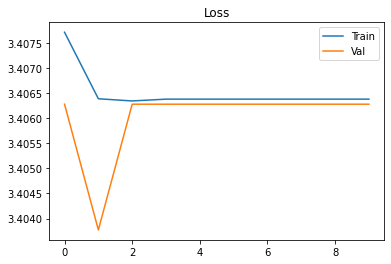

In [33]:
fig, ax = plt.subplots()
ax.set_title("Loss")
ax.plot(train_losses, label = "Train")
ax.plot(val_losses, label = "Val")
ax.legend()
plt.show()